In [3]:
import sys
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif as MIC
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from sklearn.naive_bayes import GaussianNB

## CZĘŚĆ 1: Podstawowa eksploracja danych


In [4]:
# Wydruk ścieżki do bieżącego katalogu:
print(os.getcwd())

F:\PYTHON pliki\projekt WZTUM


In [5]:
# Wczytujemy dane
data = pd.read_excel(r'F:\\PYTHON pliki\\projekt WZTUM\\Rice_MSC_Dataset.xlsx')

In [6]:
data.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,ALLdaub4L,ALLdaub4a,ALLdaub4b,ALLdaub4Y,ALLdaub4Cb,ALLdaub4Cr,ALLdaub4XX,ALLdaub4YY,ALLdaub4ZZ,CLASS
0,7805,437.915,209.8215,48.0221,0.9735,99.6877,0.9775,7985,0.3547,4.3693,...,113.9924,65.0610,59.5989,104.8552,67.8779,63.0828,0.3673,0.3793,0.4733,Basmati
1,7503,340.757,138.3361,69.8417,0.8632,97.7400,0.9660,7767,0.6637,1.9807,...,105.7055,64.3685,62.2084,96.8375,65.5371,63.5832,0.3014,0.3144,0.3641,Arborio
2,5124,314.617,141.9803,46.5784,0.9447,80.7718,0.9721,5271,0.4760,3.0482,...,109.7155,62.6423,58.7439,100.2352,68.9753,59.8342,0.3233,0.3445,0.4448,Jasmine
3,7990,437.085,201.4386,51.2245,0.9671,100.8622,0.9659,8272,0.6274,3.9325,...,116.5405,64.9069,60.2562,107.2560,67.3298,63.2237,0.3880,0.4020,0.4904,Basmati
4,7433,342.893,140.3350,68.3927,0.8732,97.2830,0.9831,7561,0.6006,2.0519,...,107.7502,64.7071,61.3549,98.8704,66.2048,63.5378,0.3184,0.3303,0.3928,Arborio


In [7]:
# Sprawdzamy czy są jakieś missing values
data.isnull().values.any() # Są

True

In [11]:
ile_brakuje = data.isnull().sum()
# Zmienne dla których są jakies brakujące wartosci
ile_brakuje[ile_brakuje > 0] 

skewB         6
kurtosisB     6
skewCb        3
skewCr        2
kurtosisCb    3
kurtosisCr    2
dtype: int64

In [12]:
# Usunę wiersze z brakującymi wartosciami.
data2 = data.dropna() # Nowe dane
len(data.index) - len(data2.index) 
# Czyli było 8 wierszy z brakującymi zmiennymi
data2 = data2.reset_index()

In [13]:
# Tworzymy roboczy zbiór danych bez ostatniej kolumny
data3 = data2.drop(['CLASS'], axis=1)
data3 = data3.drop(['index'], axis=1)
data4 = data2[['CLASS']]

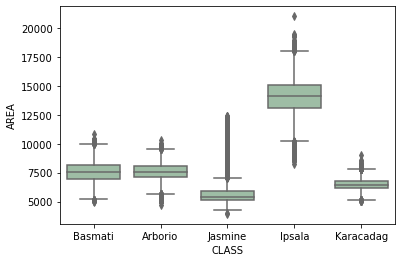

In [14]:
# Rysujemy boxploty dotyczące AREA dla różnych rodzajów ryżu
data_powierzchnia = data2[['AREA','CLASS']]
box_area = sns.boxplot(x='CLASS', y='AREA', data=data_powierzchnia, color='#99c2a2')

In [15]:
Ipsala = data_powierzchnia.loc[data_powierzchnia['CLASS'] == 'Ipsala']
Ipsala = Ipsala.reset_index()

In [16]:
Ipsala[(Ipsala['AREA'] > 12500) & (Ipsala['AREA'] < 15000)].shape[0] 
# Ponad połowa wartosci w srodku boxplota

8827

In [18]:
Ipsala[Ipsala['AREA'] > 20000].shape[0] #jeden mocny outlier

1

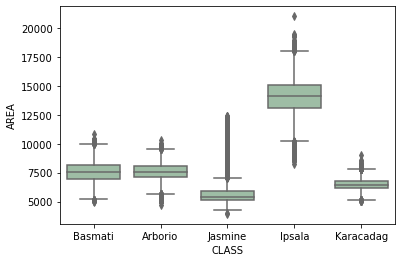

In [22]:
ax = sns.boxplot(x='CLASS', y='AREA', data=data_powierzchnia, color='#99c2a2')

# Boxplot stworzony dla wszystkich typów ryżu wskazuje na to, że są istotne różnice w powierzchni jeżeli chodzi o Ipsala, 
# Karacadag, Jasmine, natomiast zbadanie powierzchni nie odróżni nam od siebie Basmati i Arborio.

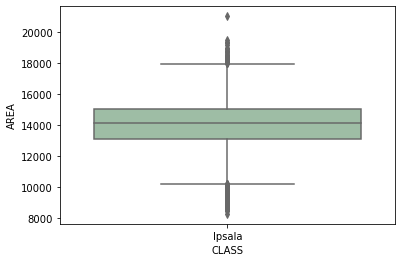

In [21]:
ax2 = sns.boxplot(x='CLASS', y='AREA', data=Ipsala, color='#99c2a2')

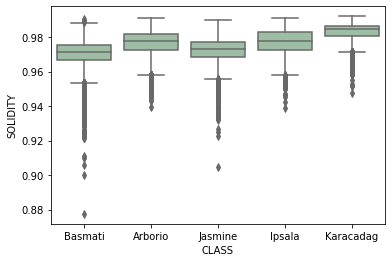

In [23]:
# Weźmiemy jeszcze trwałosć, żeby może odróżnić dwa pozostałe rodzaje ryżu
data_trwalosc = data2[['SOLIDITY','CLASS']]
box_trwalosc = sns.boxplot(x='CLASS', y='SOLIDITY', data=data_trwalosc, color='#99c2a2')
# Powinno nam odróżnić basmati od arborio

## CZĘŚĆ 2: Feature selection - DRZEWA DECYZYJNE

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(data3, data4, test_size=0.1)
mi_score = MIC(X_train, Y_train.values.ravel())
mi_score

array([0.91901151, 0.95115715, 0.94207252, 0.97876968, 1.28353787,
       0.91951345, 0.22232464, 0.91937052, 0.49268341, 1.28739978,
       1.31841648, 1.29496299, 0.98262784, 0.92358167, 1.29544359,
       0.20561015, 0.55021114, 0.52075333, 0.28591908, 0.62462705,
       0.62808069, 0.61377716, 0.37511475, 0.40668488, 0.331232  ,
       0.53853324, 0.56704554, 0.48228951, 0.81185684, 0.86204631,
       0.83396924, 0.58281681, 0.6140111 , 0.35012825, 0.32637466,
       0.56770102, 0.66507367, 0.31319996, 0.43432834, 0.40580941,
       0.20110009, 0.29884945, 0.56564246, 0.54704525, 0.52988921,
       0.31685941, 0.52121097, 0.77444628, 0.88335289, 0.64316526,
       0.53040393, 0.57462826, 0.39065008, 0.44239787, 0.44214293,
       0.55207967, 0.17992035, 0.28419645, 0.86976945, 0.83947572,
       0.90283955, 0.51278402, 0.8726341 , 0.4784214 , 0.63018546,
       0.57689486, 0.38565882, 0.36435076, 0.43365129, 0.2210719 ,
       0.54627638, 0.23459107, 0.18389993, 0.86312912, 0.82595

(array([14., 15., 21., 26.,  2.,  8., 13.,  2.,  0.,  5.]),
 array([0.17992035, 0.29376996, 0.40761958, 0.52146919, 0.6353188 ,
        0.74916842, 0.86301803, 0.97686764, 1.09071725, 1.20456687,
        1.31841648]),
 <BarContainer object of 10 artists>)

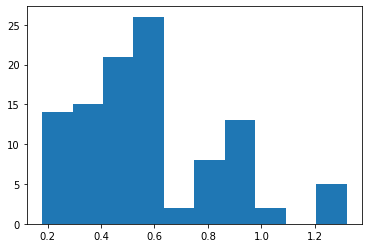

In [26]:
np.histogram(mi_score)
plt.hist(mi_score) 
# Widzimy, że najwięcej zmiennych wpada w przedział [0.4,0.6]

In [27]:
# Wybiorę zmienne, które mają mi_score > 0.5
mi_score_selected_index = np.where(mi_score > 0.5)[0] 
# Wybieram zmienne z odpowiednio dużym mi_score
X_2 = data3[data3.columns[mi_score_selected_index - 1]] 

In [28]:
X_train_2, X_test_2, Y_train2, Y_test2 = train_test_split(X_2, data4, test_size=0.1)

model_1 = DTC().fit(X_train,Y_train)
model_2 = DTC().fit(X_train_2,Y_train2)

In [31]:
score_1 = model_1.score(X_test,Y_test)
score_1

0.9962666666666666

In [32]:
score_2 = model_2.score(X_test_2,Y_test2)
score_2

0.9968

In [34]:
# Liczba zmiennych objasniajacych które zostały:    
len(data3.columns[mi_score_selected_index - 1]) 
# Czyli widzimy, że pomimo usunięcia 63 zmiennych, model praktycznie nie stracił na jakosci

63

In [35]:
# Idziemy dalej
mi_score_selected_index2 = np.where(mi_score > 0.8)[0] 
X_3 = data3[data3.columns[mi_score_selected_index2 - 1]] 
X_train_3, X_test_3, Y_train3, Y_test3 = train_test_split(X_3, data4, test_size=0.1)
model_3 = DTC().fit(X_train_3,Y_train3)
score_3 = model_3.score(X_test_3,Y_test3)
score_3

0.9929333333333333

In [36]:
# Liczba zmiennych objasniajacych które zostały:
len(data3.columns[mi_score_selected_index2 - 1])

26

In [37]:
# Wciąż jest bardzo dobrze, idziemy dalej.
mi_score_selected_index3 = np.where(mi_score > 0.95)[0]
X_4 = data3[data3.columns[mi_score_selected_index2 - 1]] 
X_train_4, X_test_4, Y_train4, Y_test4 = train_test_split(X_4, data4, test_size=0.1)
model_4 = DTC().fit(X_train_4,Y_train4)
score_4 = model_4.score(X_test_4,Y_test4)
score_4

0.9916

In [38]:
# Liczba zmiennych objasniajacych które zostały:
len(data3.columns[mi_score_selected_index3 - 1])
# Zostawiamy te 8 zmiennych.

8

## CZĘŚĆ 3: LASY LOSOWE

In [39]:
model = RF()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train_4, Y_train4, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.995 (0.001)


In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(data3, data4, test_size=0.1)
n_scores_2 = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (mean(n_scores_2), std(n_scores_2)))

Accuracy: 0.999 (0.000)


## CZĘŚĆ 4: NAIWNY BAYES

In [41]:
gnb = GaussianNB()
Y_pred = gnb.fit(X_train_4, Y_train4.values.ravel()).predict(X_test_4)

print(classification_report(Y_test4, Y_pred))

              precision    recall  f1-score   support

     Arborio       0.47      0.30      0.37      1478
     Basmati       0.52      0.61      0.56      1509
      Ipsala       0.98      0.99      0.98      1543
     Jasmine       0.90      0.68      0.77      1480
   Karacadag       0.60      0.85      0.70      1490

    accuracy                           0.69      7500
   macro avg       0.69      0.69      0.68      7500
weighted avg       0.70      0.69      0.68      7500



In [42]:
# Sprawdźmy jeszcze dla wiekszej liczby zmiennych
Y_pred_wiecej = gnb.fit(X_train_3, Y_train3.values.ravel()).predict(X_test_3)

print(classification_report(Y_test3, Y_pred_wiecej))

              precision    recall  f1-score   support

     Arborio       0.49      0.33      0.40      1474
     Basmati       0.54      0.62      0.58      1540
      Ipsala       0.98      0.99      0.98      1465
     Jasmine       0.90      0.68      0.78      1470
   Karacadag       0.61      0.85      0.71      1551

    accuracy                           0.69      7500
   macro avg       0.70      0.69      0.69      7500
weighted avg       0.70      0.69      0.69      7500



In [43]:
Y_pred_wiecej_2 = gnb.fit(X_train, Y_train.values.ravel()).predict(X_test)

print(classification_report(Y_test, Y_pred_wiecej_2))

              precision    recall  f1-score   support

     Arborio       0.78      0.53      0.63      1503
     Basmati       0.65      0.73      0.69      1548
      Ipsala       0.98      0.99      0.99      1492
     Jasmine       0.91      0.68      0.78      1483
   Karacadag       0.60      0.87      0.71      1474

    accuracy                           0.76      7500
   macro avg       0.78      0.76      0.76      7500
weighted avg       0.78      0.76      0.76      7500



## CZĘŚĆ 5: KNN

In [44]:
# Dla wybranych 8 zmiennych
X_train_4, X_test_4, Y_train4, Y_test4 = train_test_split(X_4, data4, test_size=0.1)

knn_2 = KNeighborsClassifier()
knn_2.fit(X_train_4, Y_train4)
przewidziane_2 = knn_2.predict(X_test_4)

print(classification_report(Y_test4, przewidziane_2))

F:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

     Arborio       0.88      0.89      0.88      1491
     Basmati       0.87      0.81      0.84      1527
      Ipsala       1.00      1.00      1.00      1434
     Jasmine       0.91      0.96      0.94      1557
   Karacadag       0.86      0.86      0.86      1491

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.90      7500
weighted avg       0.90      0.90      0.90      7500



In [45]:
knn_3=KNeighborsClassifier()
knn_3.fit(X_train, Y_train)
przewidziane_3 = knn_3.predict(X_test)

print(classification_report(Y_test, przewidziane_3))

F:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

     Arborio       0.92      0.94      0.93      1503
     Basmati       0.89      0.85      0.87      1548
      Ipsala       1.00      1.00      1.00      1492
     Jasmine       0.93      0.97      0.95      1483
   Karacadag       0.88      0.86      0.87      1474

    accuracy                           0.92      7500
   macro avg       0.92      0.92      0.92      7500
weighted avg       0.92      0.92      0.92      7500



## CZĘŚĆ 6: MODEL LINIOWY - REGRESJA LOGISTYCZNA 

In [46]:
# Dla 8 zmiennych
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [57]:
model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(model, X_train_4, Y_train4, scoring='accuracy', cv=cv, n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.831 (0.004)


In [58]:
# Sprawdźmy jak przewidzi nam rodzaje ryżu z X_test_4, Y_test4
model.fit(X_train_4, Y_train4)
# Przewidujemy etykiete
yhat = model.predict(X_test_4)

print(classification_report(Y_test4, yhat))

F:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
F:\anaconda\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


              precision    recall  f1-score   support

     Arborio       0.77      0.86      0.81      1491
     Basmati       0.75      0.80      0.78      1527
      Ipsala       1.00      1.00      1.00      1434
     Jasmine       0.75      0.65      0.69      1557
   Karacadag       0.87      0.83      0.85      1491

    accuracy                           0.82      7500
   macro avg       0.83      0.83      0.83      7500
weighted avg       0.83      0.82      0.82      7500



In [49]:
print('Przewidywana klasa: %s' % yhat)

Przewidywana klasa: ['Arborio' 'Basmati' 'Jasmine' ... 'Ipsala' 'Arborio' 'Ipsala']


In [50]:
# Przewidujemy multinomial probability distribution
yhat_1 = model.predict_proba(X_test_4)

print('Predicted Probabilities: %s' % yhat_1)
# i faktycznie wybiera te z największymi prawdopodobieństwami

Predicted Probabilities: [[7.25284307e-01 1.02356674e-01 9.22782602e-02 7.10990029e-02
  8.98175584e-03]
 [5.30275002e-02 8.22198934e-01 5.35886661e-04 7.69319745e-02
  4.73057043e-02]
 [4.72641245e-06 4.16489856e-01 7.91027088e-11 5.83073922e-01
  4.31495210e-04]
 ...
 [3.28698040e-02 4.94501750e-08 9.67129553e-01 5.93377025e-07
  1.27689411e-10]
 [6.51983128e-01 1.11390180e-01 1.87432252e-01 4.49531387e-02
  4.24130175e-03]
 [2.71035767e-05 1.07135734e-06 9.99971646e-01 1.79435155e-07
  1.21418981e-14]]


In [51]:
# Dla wszystkich zmiennych
cv2 = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores2 = cross_val_score(model, X_train, Y_train.values.ravel(), scoring='accuracy', cv=cv2, n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores2), std(n_scores2)))

Mean Accuracy: 0.777 (0.004)


In [52]:
# Sprawdźmy jak przewidzi nam rodzaje ryżu z X_test, Y_test
log_pred2 = model.fit(X_train, Y_train.values.ravel()).predict(X_test)
print(classification_report(Y_test, log_pred2))

F:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

     Arborio       0.66      0.86      0.75      1503
     Basmati       0.73      0.77      0.75      1548
      Ipsala       0.97      0.99      0.98      1492
     Jasmine       0.64      0.44      0.52      1483
   Karacadag       0.85      0.81      0.83      1474

    accuracy                           0.77      7500
   macro avg       0.77      0.77      0.77      7500
weighted avg       0.77      0.77      0.77      7500



In [53]:
# Dla pojedynczej obserwacji
print('Predicted Class: %s' % log_pred2[0]) 

Predicted Class: Arborio


In [54]:
print('Predicted Class: %s' % log_pred2)

Predicted Class: ['Arborio' 'Arborio' 'Arborio' ... 'Karacadag' 'Jasmine' 'Ipsala']


In [55]:
yhat_2 = model.predict_proba(X_test)

print('Predicted Probabilities: %s' % yhat_2) 

Predicted Probabilities: [[4.97414431e-01 1.29659513e-02 3.36284885e-06 2.76864106e-01
  2.12752150e-01]
 [5.39904038e-01 5.65317108e-03 7.19298049e-03 4.47170622e-01
  7.91883570e-05]
 [8.69771178e-01 9.98304530e-04 2.09619657e-06 1.23414416e-01
  5.81400534e-03]
 ...
 [3.44513880e-02 2.76629823e-01 2.00036239e-09 9.24014228e-02
  5.96517365e-01]
 [1.60410089e-01 3.41362098e-01 1.01552474e-05 4.10887261e-01
  8.73303964e-02]
 [2.76256617e-07 4.73319884e-13 9.99999724e-01 1.22654857e-11
  9.74085116e-19]]


## CZĘŚĆ 7: PCA

In [63]:
# Standaryzujemy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
x = StandardScaler().fit_transform(X_train) 

pca = PCA(n_components=8)
pca.fit(x)

print(pca.explained_variance_ratio_)

#Chcemy mieć przynajmniej około 60% wariancji, tyle kierunków bysmy chcieli

[0.41957029 0.16245409 0.09173971 0.07078066 0.05765284 0.03904761
 0.02833483 0.02029483]


In [61]:
np.sum(pca.explained_variance_ratio_)

0.889874867739401

 Dla 8 mamy 0.889874867739401 wariancji
 
 Wniosek: W danych mamy bardzo dużo zmiennych, które niezbyt dobrze wyjasniają typ ryżu,
 a jest kilka zmiennych, które robią to bardzo dobrze.
 
 
 8 składowych głównych wystarcza do klasyfikacji na wysokim poziomie.
 
 14 składowych wyjasnia łącznie ponad 95% wariancji - klasyfikacji na bardzo wysokim poziomie.